In [131]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim

image_size = 28
patch_size = 28
k_points = 3

epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [132]:
def create_patch_grid(k, patch_size):
    lin_coords = torch.linspace(-1, 1, steps=patch_size)
    x_grid, y_grid = torch.meshgrid(lin_coords, lin_coords, indexing="xy")
    grid = torch.stack([x_grid, y_grid], dim=-1)
    grid = grid.unsqueeze(0).repeat(k, 1, 1, 1)
    return grid

class KeypointDetector(nn.Module):
    def __init__(self, k):
        super().__init__()
        self.k = k
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
        )
        self.fc = nn.Linear(32, 2 * k)

    def forward(self, x):
        features = self.cnn(x)
        coords = self.fc(features.view(x.size(0), -1))
        coords = coords.view(-1, self.k, 2)
        coords = coords.clamp(-1, 1)
        return coords

class PatchClassifier(nn.Module):
    def __init__(self, k, patch_size, num_classes=10):
        super().__init__()
        self.k = k
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(16 * patch_size * patch_size, 64),
            nn.ReLU()
        )
        self.classifier = nn.Linear(64 * k, num_classes)

    def forward(self, patches):
        B, k, C, H, W = patches.shape
        patches = patches.view(B * k, C, H, W)
        features = self.cnn(patches)
        features = features.view(B, k * 64)
        out = self.classifier(features)
        return out

class KeypointPatchModel(nn.Module):
    def __init__(self, k=k_points, patch_size=patch_size):
        super().__init__()
        self.k = k
        self.patch_size = patch_size
        self.detector = KeypointDetector(k)
        self.classifier = PatchClassifier(k, patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        coords = self.detector(x)
        grid = create_patch_grid(self.k, self.patch_size).to(x.device)
        coords = coords.unsqueeze(2).unsqueeze(2)
        patch_grid = grid.unsqueeze(0) + coords
        patch_grid = patch_grid.view(B * self.k, self.patch_size, self.patch_size, 2)
        x_rep = x.unsqueeze(1).repeat(1, self.k, 1, 1, 1)
        x_rep = x_rep.view(B * self.k, C, H, W)
        patches = F.grid_sample(x_rep, patch_grid, align_corners=True)
        patches = patches.view(B, self.k, C, self.patch_size, self.patch_size)
        return self.classifier(patches)


    # def forward(self, x):
    #     B, C, H, W = x.shape
    #     coords = self.detector(x)

    #     lin_coords = torch.linspace(-1, 1, self.patch_size, device=x.device)
    #     y, x_grid = torch.meshgrid(lin_coords, lin_coords, indexing='ij')
    #     base_grid = torch.stack([x_grid, y], dim=-1)

    #     base_grid = base_grid.view(1, 1, self.patch_size, self.patch_size, 2)
    #     grid = base_grid + coords.view(B, self.k, 1, 1, 2)

    #     grid = grid.view(B * self.k, self.patch_size, self.patch_size, 2)
    #     x_rep = x.unsqueeze(1).repeat(1, self.k, 1, 1, 1).view(B * self.k, C, H, W)

    #     patches = F.grid_sample(x_rep, grid, align_corners=True)
    #     patches = patches.view(B, self.k, C, self.patch_size, self.patch_size)

    #     return self.classifier(patches)


In [133]:
# Load MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

# train_dataset = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
# test_dataset = datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000)

model = KeypointPatchModel(k=k_points, patch_size=patch_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [134]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
    accuracy = 100. * correct / len(loader.dataset)
    avg_loss = total_loss / len(loader)
    return avg_loss, accuracy


def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
    accuracy = 100. * correct / len(loader.dataset)
    avg_loss = total_loss / len(loader)
    return avg_loss, accuracy

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")

test_loss, test_acc = evaluate(model, test_loader, criterion)
print("\n")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Epoch 1/10, Train Loss: 0.1730, Train Accuracy: 94.72%
Epoch 2/10, Train Loss: 0.0603, Train Accuracy: 98.11%
Epoch 3/10, Train Loss: 0.0382, Train Accuracy: 98.79%
Epoch 4/10, Train Loss: 0.0276, Train Accuracy: 99.09%
Epoch 5/10, Train Loss: 0.0203, Train Accuracy: 99.33%
Epoch 6/10, Train Loss: 0.0159, Train Accuracy: 99.47%
Epoch 7/10, Train Loss: 0.0120, Train Accuracy: 99.61%
Epoch 8/10, Train Loss: 0.0105, Train Accuracy: 99.64%
Epoch 9/10, Train Loss: 0.0081, Train Accuracy: 99.72%
Epoch 10/10, Train Loss: 0.0078, Train Accuracy: 99.75%


Test Loss: 0.0697, Test Accuracy: 98.36%


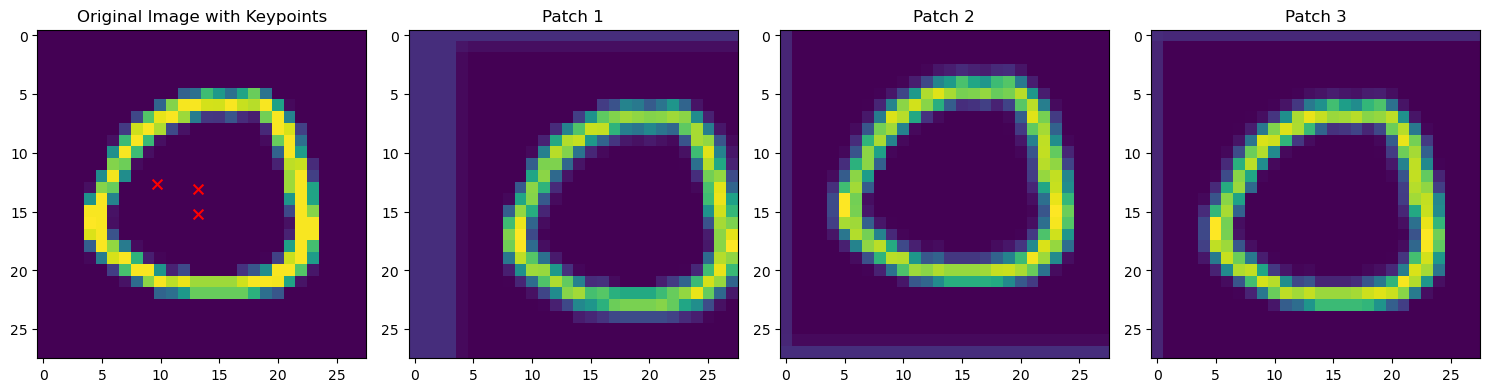

Predicted label: 0 	 True label: 0 	 Correct: True


In [137]:
import matplotlib.pyplot as plt
import random

def show_patches_and_keypoints(model, loader):
    model.eval()
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        keypoints = model.detector(images)  
        vis_keypoints = keypoints.clone()   

        B, C, H, W = images.shape
        grid = create_patch_grid(k_points, patch_size).to(device)
        keypoints = keypoints.unsqueeze(2).unsqueeze(2)  
        patch_grid = grid.unsqueeze(0) + keypoints
        patch_grid = patch_grid.view(B * k_points, patch_size, patch_size, 2)
        images_rep = images.unsqueeze(1).repeat(1, k_points, 1, 1, 1)
        images_rep = images_rep.view(B * k_points, C, H, W)
        patches = F.grid_sample(images_rep, patch_grid, align_corners=True)
        patches = patches.view(B, k_points, C, patch_size, patch_size)

    idx = random.randint(0, B - 1)
    fig, axes = plt.subplots(1, k_points + 1, figsize=(15, 5))
    axes[0].imshow(images[idx].cpu().squeeze())
    axes[0].scatter(
        (vis_keypoints[idx, :, 0].cpu().numpy() + 1) * image_size / 2,
        (vis_keypoints[idx, :, 1].cpu().numpy() + 1) * image_size / 2,
        c="red",
        s=50,
        marker="x"
    )
    axes[0].set_title("Original Image with Keypoints")

    for i in range(k_points):
        axes[i + 1].imshow(patches[idx, i].cpu().squeeze())
        axes[i + 1].set_title(f"Patch {i + 1}")

    plt.tight_layout()
    plt.show()

    with torch.no_grad():
        output = model(images[idx].unsqueeze(0))
        pred = output.argmax(1).item()
        print(f"Predicted label: {pred} \t True label: {labels[idx].item()} \t Correct: {pred == labels[idx].item()}")


show_patches_and_keypoints(model, test_loader)